# Class 19: Hypothesis tests for proportions

Plan for today:
- Hypothesis tests for proportions


## Notes on the class Jupyter setup

If you have the *ydata123_2024a* environment set up correctly, you can get the class code using the code below (which presumably you've already done given that you are seeing this notebook).  

In [3]:
import YData

# YData.download.download_class_code(19)   # get class code    
# YData.download.download_class_code(19, TRUE) # get the code with the answers 


YData.download_data("movies.csv")

There are also similar functions to download the homework:

In [4]:
# YData.download.download_class_file('project_template.ipynb', 'homework')  # downloads the class project template (hopefully you've already done this)

If you are using colabs, you should install polars and the YData packages by uncommenting and running the code below.

In [5]:
# !pip install https://github.com/emeyers/YData_package/tarball/master

If you are using google colabs, you should also uncomment and run the code below to mount the your google drive

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
import statistics
import pandas as pd
import numpy as np
from urllib.request import urlopen

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Hypothesis test for proportions

In hypothesis testing, we start with a claim about a population parameter (e.g., µ = 4.2, or π = 0.25).

This claim implies we should get a certain distribution of statistics, called "The null distribution". 

If our observed statistic is highly unlikely to come from the null distribution, we reject the claim. 

We can break down the process of running a hypothesis test into 5 steps. 

1. State the null and alternative hypothesis
2. Calculate the observed statistic of interest
3. Create the null distribution 
4. Calculate the p-value 
5. Make a decision

Let's run through these steps now!


#### Step 1: State the null and alternative hypothesis

$H_0: \pi = 0.5$

$H_A: \pi < 0.5$


#### Step 2: Calculate the observed statistic of interest


In [8]:
# load the data

movies = pd.read_csv("movies.csv")

movies.head(3)

,year,imdb,title,test,clean_test,binary,budget,domgross,intgross,code,budget_2013$,domgross_2013$,intgross_2013$,period code,decade code
0,2013,tt1711425,21 &amp; Over,notalk,notalk,FAIL,13000000,25682380.0,42195766.0,2013FAIL,13000000,25682380.0,42195766.0,1.0,1.0
1,2012,tt1343727,Dredd 3D,ok-disagree,ok,PASS,45000000,13414714.0,40868994.0,2012PASS,45658735,13611086.0,41467257.0,1.0,1.0
2,2013,tt2024544,12 Years a Slave,notalk-disagree,notalk,FAIL,20000000,53107035.0,158607035.0,2013FAIL,20000000,53107035.0,158607035.0,1.0,1.0


In [9]:
# reduce data to a smaller number of columns: "title" and "binary"

movies_smaller = movies[["title", "binary"]]

In [10]:
# calculate the proportion of movies that pass the Bechdel test

booleans_passed = movies_smaller["binary"] == "PASS"

prop_passed = np.mean(booleans_passed)

prop_passed


0.447603121516165

#### Step 3: Create the null distribution 

We need to create a null distribution, which is the distribution of statistics we would expect to get if the null hypothesis is true. 

**Question**: about what percent of the movies would we expect to pass the Bechdel test if the null hypothesis was true? 

**Answer**: 50%

Let's create simulated data that is consistent with this!


In [11]:
# Let's generate one proportion consistent with the null hypothesis

# get the total number of movies in our dataset n
n = movies.shape[0]
print(n)

# generate random sample indicating if each of the n movies passed the Bechdel test
null_sample = np.random.rand(n) < .5

# get the proportion of simulated movies that passed the Bechdel test
np.mean(null_sample)


1794


0.4927536231884058

In [12]:
# Let's write a function to generate a proportions consistent with a null hypothesis

def generate_proportion(n, null_prop):
    random_sample = np.random.rand(n) <= null_prop
    return np.mean(random_sample)


# call the function to generate a p-hat consistent with the null hypothesis
generate_proportion(1794, .5)

0.4916387959866221

In [13]:
# Let's generate a null distribution 

null_dist = []

for i in range(10000):    
    null_dist.append(generate_proportion(1794, .5))


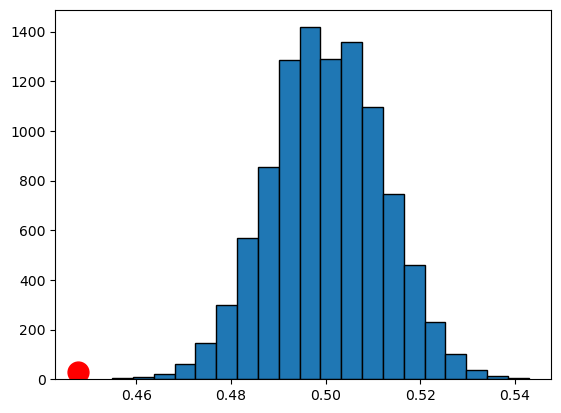

In [14]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 20) #, range = (.4, .6));
plt.plot(prop_passed, 30, '.', markersize = 30, color = "red");

#### Step 4: Calculate the p-value 

Calculate the proportion of points in the null distribution that are more extreme than the observed statistic. 


In [15]:
# Calculate the p-value

# create a Boolean vector indicating whether each p-hat in the null distribution 
# was greater than the observed proportion that passed the Bechdel test
stats_more_extreme = np.array(null_dist) <= prop_passed

print(stats_more_extreme[0:5])

# calculate the p-value 
p_value = np.mean(stats_more_extreme)

p_value

[False False False False False]


0.0

#### Step 5: Make a decision

Since the p-value is very small (essentially zero) it is very unlikely that our statistic come from the null distribution. Thus we will reject the null hypothesis and conclude that less than 50% of movies pass the Bechdel test. 


## 2. Another example: Plan B 

Multiple-choice questions on Advanced Placement exams have five options: A, B, C, D, and E. 

A random sample of the correct choice on 400 multiple-choice questions on a variety of AP shows that B was the correct answer 90 of the 400 questions. 

Does this provide evidence that B occurs at a higher rate than what is expected if each question is equally likely? 

#### Step 1: State the null and alternative hypothesis

$H_0: \pi_b = 0.2$

$H_A: \pi_b > 0.2$

#### Step 2: Calculate the observed statistic of interest

I.e., calculate the observed proportion of questions that were b and save it to the name `obs_prop`.


In [21]:
obs_prop = 90/400

obs_prop 

0.225

#### Step 3: Create the null distribution 

We need to create a null distribution, which is the distribution of statistics we would expect to get if the null hypothesis is true. 

**Question**: About what percent of the answers would we expect to be B if the null hypothesis was true? 

**Answer**: About 1/5 answers or 20%

Let's create simulated data that is consistent with this!

In [22]:
# generate the null distribution

null_dist = []

for i in range(10000):    
    null_dist.append(generate_proportion(400, .2))

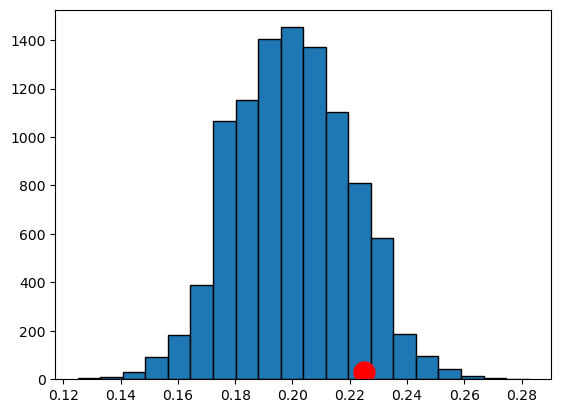

In [23]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 20) #, range = (.4, .6));
plt.plot(obs_prop, 30, '.', markersize = 30, color = "red");

#### Step 4: Calculate the p-value 

Calculate the proportion of points in the null distribution that are more extreme than the observed statistic; i.e., calculate the p-value. 

In [24]:
pvalue = np.mean(np.array(null_dist) >= obs_prop)

pvalue

0.116

#### Step 5: Make a decision

Typically if the p-value is less than 0.05 we reject the null hypothesis and conclude the the alternative hypothesis is likely. 


## 3. Hypothesis test for multiple proportions

In a hypothesis test for multiple proportions, we are testing whether each proportion is equal to a particular value. I.e., we are testing whether $\pi_1 = p_1$, $\pi_2 = p_2$, ..., $\pi_k = p_k$, for some proportions $p_1$, $p_2$, ..., $p_k$.

A special case of this is whether all populations proportions are the same, which can be written as: $\pi_1 = \pi_2 = ... = \pi_k$.


### Movivating example: ALCU vs. Almeda County

As a motivating example, let's look look at a report by the American Civil Liberties Union (ACLU) of Almada County jury selection. In particular, the ACLU claimed that jury panels in Almeda were not representative of the underlying demographics of the population of the citizens who lived there. 

The demographics of Almeda county, and the proportion of people selected to be on jury panels, is shown in the DataFrame below, which is based on 1453 people selected to be on jury panels. Let's use this data to run a hypothesis test to examine whether the proportion of people selected to be on jury panels is consistent with the underlying demographics of Almeda. 


,Ethnicity,Population proportions,Jury proportions
0,Asian,0.15,0.26
1,Black,0.18,0.08
2,Latino,0.12,0.08
3,White,0.54,0.54
4,Other,0.01,0.04


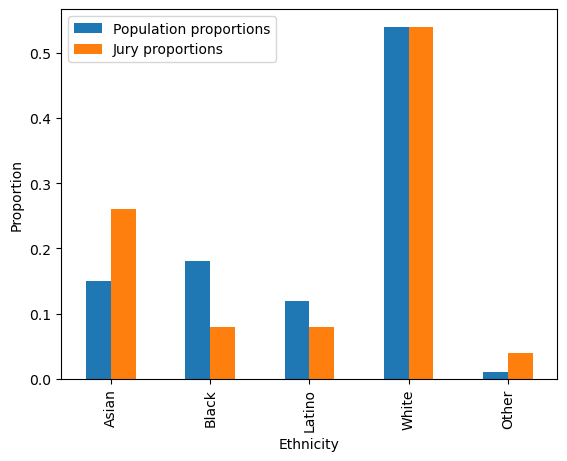

In [48]:

ethnicities = np.array(['Asian', 'Black', 'Latino', 'White', 'Other'])
population_proportions = np.array([0.15, 0.18, 0.12, 0.54, 0.01])
panel_proportions = np.array([0.26, 0.08, 0.08, 0.54, 0.04])


demographics = pd.DataFrame({"Ethnicity": ethnicities, 
                             "Population proportions": population_proportions, 
                             "Jury proportions": panel_proportions})

display(demographics)

# built in pandas plotting functions
demographics.plot.bar("Ethnicity");
plt.ylabel("Proportion");

### Step 1: State the null and alternative hypotheses

**In words** 

Null hypothesis: The proportions of members on the jury panels of different ethnicities match the underlying demographics. 

Alternative hypothesis: The proportion of at least one ethnicity does not match the underlying demographics. 


**In symbols**

$H_0$: $\pi_{Asian} = .15$,  $\pi_{Black} = .18$,  $\pi_{Latino} = .12$,  $\pi_{White} = .54$,  $\pi_{Other} = .01$

$H_A$: At least one $\pi_{i}$ is different from the values specified in the null hypothesis



### Step 2: Calculate the observed statistic

For our observed statistic we will use the Total Variational Distance (TVD) which is defined as:  $TVD ~ = ~ \sum_{i = 1}^{k} |\pi_i - \hat{p}_i |$

Let's write a function `total_variation_distance(distribution_1, distribution_2)` that can calculate the TVD. We can then use this function to calculate the TVD statistic value for the jurors in Almeda county.


In [49]:
def total_variation_distance(distribution_1, distribution_2):
    
    return np.sum(np.abs(distribution_1 - distribution_2))


# calculate the total variation distance between population proportions and the observed proportions
observed_statistic_value = total_variation_distance(panel_proportions, population_proportions)

observed_statistic_value

0.28

### Step 3: Create the null distribution 

To create the null distribution we need to simulate drawing random sample proportions from the underlying population.

To do this we can generate (uniform) random numbers between 0 and 1. We can then use the `pd.cut()` function to simulate randomly selected jurors ethnicities and convert these to proportions. 

Once we have these proportions, we can calculate the TVD. If we repreat this process 1,000 times we can get a null distribution. 

In [50]:
# calculate the cumulative proportions we can use to split the data into categories consistent with the null hypothesis

cumulative_proportions = np.append(0, np.cumsum(population_proportions))

cumulative_proportions


array([0.  , 0.15, 0.33, 0.45, 0.99, 1.  ])

In [51]:
# generate random jury panelist ethnicities

# number of jury members
num_jury_members = 1453

# generate random numbers between 0 and 1 for each jury member
rand_nums = np.random.rand(num_jury_members)

# generate random ethnicities for each jury member
one_sample = pd.cut(rand_nums, 
                    cumulative_proportions, 
                    labels = ethnicities, 
                    ordered = False)

print(one_sample[0:5])

['White', 'Asian', 'White', 'Latino', 'Latino']
Categories (5, object): ['Asian', 'Black', 'Latino', 'White', 'Other']


In [52]:
# get the proportions from our sample

# get how many simulated jury members there were for each ethnicity
unique, counts = np.unique(one_sample, return_counts=True)

# convert to proportions
sample_proportions = counts/sum(counts)

sample_proportions

array([0.14659326, 0.18995182, 0.10942877, 0.00825877, 0.54576738])

In [53]:
# Let's convert the following steps into one function

def get_sample_proportions(sample_size, true_proportions):
    
    cumulative_proportions = np.append(0, np.cumsum(true_proportions))
    
    rand_nums = np.random.rand(sample_size)
    one_sample = pd.cut(rand_nums, cumulative_proportions)
    unique, counts = np.unique(one_sample, return_counts=True)
    
    return counts/sum(counts)


# test the function
get_sample_proportions(1453, population_proportions)



array([0.16104611, 0.16379904, 0.11768754, 0.54645561, 0.0110117 ])

In [54]:
# Step 3: create null distribution 

null_dist = []

num_null_dist_points = 1000

for i in range(num_null_dist_points):
    
    curr_sample_props = get_sample_proportions(1453, population_proportions)
    curr_tvd = total_variation_distance(curr_sample_props, population_proportions)
    null_dist.append(curr_tvd)

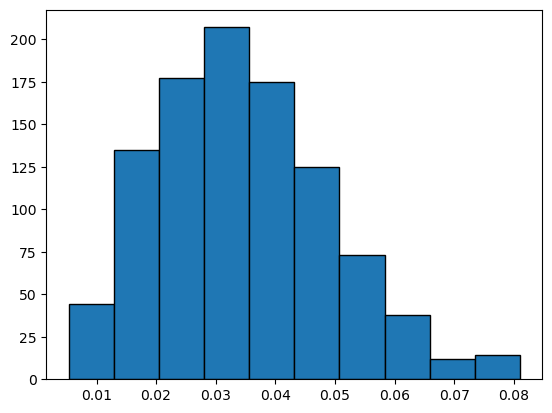

In [55]:
# plot the null distribution as a histogram

plt.hist(null_dist, edgecolor = "black");


### Step 4: Calculate the p-value

The p-value is the proportion of points in the null distribution that are more extreme than the observed statistic. 


In [56]:
p_value = np.mean(null_dist >= observed_statistic_value)

p_value

0.0

### Step 5: Draw a conclusion

Since the p-value is very small, it is very unlikely our statistic comes from the null distribution. Thus we can reject the null distribution and conclude that the proportion of members of different ethnicities on jury panels in Almeda do not reflect the underlying distribution of ethnicities in the population. 
